In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import itertools

from User_based_CF import *
from Item_based_CF import *

import torch
import torch.nn as nn

from sklearn.metrics import mean_squared_error
import math

from Matrix_Factorization import *
import json

In [2]:
# Create a user-item matrix
def create_user_item_matrix(data):
    """
    data: (user, item, rating, timestamp)
    """
    user_list = rating_data["User_id"].values
    item_list = rating_data["Item_id"].values
    rating_list = rating_data["Rating"].values
    user_item_matrix_data = pd.crosstab(index=user_list, columns=item_list, values=rating_list, aggfunc=np.mean,\
        rownames=["User_id"], colnames=["Item_id"])
    return user_item_matrix_data

In [3]:
# Create a user-item matrix
def create_user_item_matrix_for_matrix_factorization(data, unique_user_id, unique_item_id):
    """
    data: (user, item, rating, timestamp)
    """
    user_item_matrix_data = pd.DataFrame(np.array([np.nan] * (len(unique_user_id) * len(unique_item_id))).reshape(len(unique_user_id), len(unique_item_id)),\
        index=unique_user_id, columns=unique_item_id)
    
    for one_index in data.index:
        user_item_matrix_data.loc[data.loc[one_index, "User_id"], data.loc[one_index, "Item_id"]] = \
            data.loc[one_index, "Rating"]
    return user_item_matrix_data

In [4]:
# Identify whether the value exists or not.
def identify_value_exist(user_item_matrix_data):
    """
    user_item_matrix_data: DataFrame
    """
    return (user_item_matrix_data.isna() == False).astype("int")

In [5]:
# Load data to dataframe
with open("ratings.data", "r") as f:
    rating_data = [i.replace("\n", "").split("\t") for i in f.readlines()]
rating_data = pd.DataFrame(np.array(rating_data), columns=["User_id", "Item_id", "Rating", "timestamp"]).astype("int")

# transform timestamp into datetime
rating_data["timestamp"] = [datetime.utcfromtimestamp(i) for i in rating_data["timestamp"]]
rating_data.head()

,User_id,Item_id,Rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [6]:
# split data
traindata, testdata = train_test_split(rating_data, test_size=0.25, random_state=12345)

In [ ]:
# transform train data into user-item matrix
user_item_matrix_data = create_user_item_matrix(traindata)

In [ ]:
similarity_method = ["pearson", "cosine"]
K_list = [3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
result_dict = dict()

for one_similarity_method in similarity_method:
    # User-based Collaborative Filtering
    user_cf = User_based_CF(traindata, user_item_matrix_data)
    user_user_correlation_data = user_cf.compute_correlation(corr_methods=one_similarity_method)

    for K in K_list:
        # 針對test data做預測以及模型評估（注意，每次計算是針對一筆資料）
        pred_user_data = list(map(lambda x: user_cf.predict_without_time(testdata.iloc[x, 0], testdata.iloc[x, 1], num_user=K), tqdm([i for i in range(testdata.shape[0])])))
        pred_user_data = [i if i > 0 else 0 for i in pred_user_data]
        result_dict[f"user-based_{one_similarity_method}_{K}"] = math.sqrt(mean_squared_error(y_true=testdata["Rating"].values, y_pred=np.array(pred_user_data)))

    # Item-based Collaborative Filtering
    item_cf = Item_based_CF(traindata, user_item_matrix_data)
    item_item_correlation_data = item_cf.compute_correlation(corr_methods=one_similarity_method)

    for K in K_list:
        # 針對test data做預測以及模型評估（注意，每次計算是針對一筆資料）
        pred_user_data = list(map(lambda x: user_cf.predict_without_time(testdata.iloc[x, 0], testdata.iloc[x, 1], num_user=K), tqdm([i for i in range(testdata.shape[0])])))
        pred_user_data = [i if i > 0 else 0 for i in pred_user_data]
        result_dict[f"item-based_{one_similarity_method}_{K}"] = math.sqrt(mean_squared_error(y_true=testdata["Rating"].values, y_pred=np.array(pred_user_data)))

# Matrix Factorization

In [7]:
# MF_with_nobias
num_user_id = 943
num_item_id = 1682

_lambda_ = 0.1
batch_size = 75000
epochs = 100
learning_rate = 1e-10

# 建立儲存list
MF_with_nobias_20_result_list = list()
MF_with_nobias_each_factor_result = dict()

# 建立Latent Factor list
latent_factor_list = [i for i in range(5, 101, 5)]

for num_features in latent_factor_list:
    print(f"==== Latent Factor: {num_features} ====")
    mf_model = Matrix_Factorization_with_nobias(num_user_id=num_user_id, 
                                                num_item_id=num_item_id, 
                                                num_features=num_features)
    for epoch in range(epochs):
        print(f"=== Epoch: {epoch} ===")
        for one_batch in range(int(traindata.shape[0]/batch_size)):
            # transform train data into user-item matrix
            user_item_matrix_data = create_user_item_matrix_for_matrix_factorization(
                traindata.iloc[one_batch*batch_size:(one_batch+1)*batch_size, :], 
                unique_user_id=list(rating_data["User_id"].unique()), 
                unique_item_id=list(rating_data["Item_id"].unique())
                )
            pred_user_item_matrix = mf_model.MF_predict_with_nobias()
            loss = mf_model.loss_func_with_nobias(true_user_item_matrix=user_item_matrix_data, 
                                                pred_user_item_matrix=pred_user_item_matrix, 
                                                _lambda_=_lambda_)
            mf_model.compute_gradients_with_nobias(_lambda_=_lambda_)
            mf_model.weight_updated_with_nobias(learning_rate=learning_rate)
            
        print(f"Loss is {loss}")
        if num_features == 20:
            MF_with_nobias_20_result_list.append(loss)
    
    user_item_matrix_data = create_user_item_matrix_for_matrix_factorization(testdata, unique_user_id=list(rating_data["User_id"].unique()), unique_item_id=list(rating_data["Item_id"].unique()))
    pred_user_item_matrix = mf_model.MF_predict_with_nobias()
    loss = mf_model.loss_func_with_nobias(true_user_item_matrix=user_item_matrix_data, 
                                        pred_user_item_matrix=pred_user_item_matrix, 
                                        _lambda_=_lambda_)
    MF_with_nobias_each_factor_result[str(num_features)] = loss

==== Latent Factor: 5 ====
=== Epoch: 0 ===
Loss is 249787.56654604783
=== Epoch: 1 ===
Loss is 249753.63040424933
=== Epoch: 2 ===
Loss is 249719.69511451255
=== Epoch: 3 ===
Loss is 249685.76067839726
=== Epoch: 4 ===
Loss is 249651.82709746345
=== Epoch: 5 ===
Loss is 249617.89437327077
=== Epoch: 6 ===
Loss is 249583.96250737886
=== Epoch: 7 ===
Loss is 249550.0315013477
=== Epoch: 8 ===
Loss is 249516.1013567373
=== Epoch: 9 ===
Loss is 249482.17207510705
=== Epoch: 10 ===
Loss is 249448.24365801679
=== Epoch: 11 ===
Loss is 249414.3161070261
=== Epoch: 12 ===
Loss is 249380.38942369504
=== Epoch: 13 ===
Loss is 249346.46360958315
=== Epoch: 14 ===
Loss is 249312.53866625024
=== Epoch: 15 ===
Loss is 249278.61459525587
=== Epoch: 16 ===
Loss is 249244.69139815972
=== Epoch: 17 ===
Loss is 249210.76907652157
=== Epoch: 18 ===
Loss is 249176.8476319011
=== Epoch: 19 ===
Loss is 249142.92706585763
=== Epoch: 20 ===
Loss is 249109.00737995145
=== Epoch: 21 ===
Loss is 249075.088575741

In [ ]:
# MF_with_bias
num_user_id = 943
num_item_id = 1682
_lambda_ = 0.1
batch_size = 75000
epochs = 100
learning_rate = 1e-10

# 建立儲存list
MF_with_bias_20_result_list = list()
MF_with_bias_each_factor_result = dict()

# 建立Latent Factor list
latent_factor_list = [i for i in range(5, 101, 5)]

user_item_matrix_data = create_user_item_matrix_for_matrix_factorization(rating_data, unique_user_id=list(rating_data["User_id"].unique()), unique_item_id=list(rating_data["Item_id"].unique()))

for num_features in latent_factor_list:
    print(f"==== Latent Factor: {num_features} ====")
    mf_model = Matrix_Factorization_with_bias(num_user_id=num_user_id, num_item_id=num_item_id, num_features=num_features, all_true_user_item_matrix=user_item_matrix_data)
    for epoch in range(epochs):
        print(f"=== Epoch: {epoch} ===")
        for one_batch in range(int(traindata.shape[0]/batch_size)):
            # transform train data into user-item matrix
            user_item_matrix_data = create_user_item_matrix_for_matrix_factorization(traindata.iloc[one_batch*batch_size:(one_batch+1)*batch_size, :], unique_user_id=list(rating_data["User_id"].unique()), unique_item_id=list(rating_data["Item_id"].unique()))
            pred_user_item_matrix = mf_model.MF_predict_with_bias()
            loss = mf_model.loss_func_with_bias(true_user_item_matrix=user_item_matrix_data, 
                                                pred_user_item_matrix=pred_user_item_matrix, 
                                                _lambda_=_lambda_)
            mf_model.compute_gradients_with_bias(_lambda_=_lambda_)
            mf_model.weight_updated_with_bias(learning_rate=learning_rate)
            
        print(f"Loss is {loss}")
        if num_features == 20:
            MF_with_bias_20_result_list.append(loss)
    
    user_item_matrix_data = create_user_item_matrix_for_matrix_factorization(testdata, unique_user_id=list(rating_data["User_id"].unique()), unique_item_id=list(rating_data["Item_id"].unique()))
    pred_user_item_matrix = mf_model.MF_predict_with_bias()
    loss = mf_model.loss_func_with_bias(true_user_item_matrix=user_item_matrix_data, 
                                        pred_user_item_matrix=pred_user_item_matrix, 
                                        _lambda_=_lambda_)
    MF_with_bias_each_factor_result[str(num_features)] = loss

==== Latent Factor: 5 ====
=== Epoch: 0 ===
Loss is 145409.16931494328
=== Epoch: 1 ===
Loss is 1133535.0007801033
=== Epoch: 2 ===
Loss is 1133511.9436355822
=== Epoch: 3 ===
Loss is 1133488.8940077233
=== Epoch: 4 ===
Loss is 1133465.851893217
=== Epoch: 5 ===
Loss is 1133442.8172887573
=== Epoch: 6 ===
Loss is 1133419.790191037
=== Epoch: 7 ===
Loss is 1133396.7705967564
=== Epoch: 8 ===
Loss is 1133373.7585026086
=== Epoch: 9 ===
Loss is 1133350.7539052987
=== Epoch: 10 ===
Loss is 1133327.7568015258
=== Epoch: 11 ===
Loss is 1133304.7671879954
=== Epoch: 12 ===
Loss is 1133281.785061413
=== Epoch: 13 ===
Loss is 1133258.8104184845
=== Epoch: 14 ===
Loss is 1133235.843255921
=== Epoch: 15 ===
Loss is 1133212.8835704324
=== Epoch: 16 ===
Loss is 1133189.9313587353
=== Epoch: 17 ===
Loss is 1133166.986617539
=== Epoch: 18 ===
Loss is 1133144.0493435636
=== Epoch: 19 ===
Loss is 1133121.1195335279
=== Epoch: 20 ===
Loss is 1133098.1971841503
=== Epoch: 21 ===
Loss is 1133075.282292154

In [13]:
with open("MF_with_bias_each_factor_result.json") as f:
    MF_with_bias_each_factor_result = json.load(f)

with open("MF_with_bias_20_result_list.json") as f:
    MF_with_bias_20_result_list = json.load(f)

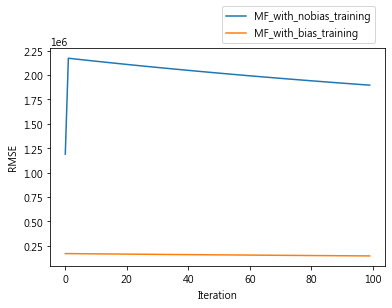

In [25]:
plt.plot(MF_with_bias_20_result_list)
plt.plot(MF_with_nobias_20_result_list)
plt.legend("center left", bbox_to_anchor=(0.5, 1), labels=["MF_with_nobias_training", "MF_with_bias_training"])
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.show()

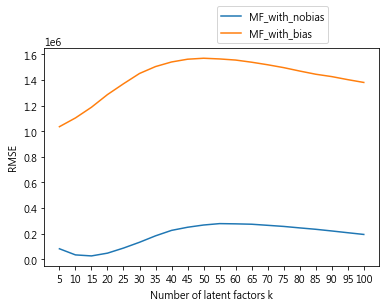

In [26]:
plt.plot(MF_with_nobias_each_factor_result.keys(), MF_with_nobias_each_factor_result.values())
plt.plot(MF_with_bias_each_factor_result.keys(), MF_with_bias_each_factor_result.values())
plt.legend("center left", bbox_to_anchor=(0.5, 1), labels=["MF_with_nobias", "MF_with_bias"])
plt.xlabel("Number of latent factors k")
plt.ylabel("RMSE")
plt.show()